In [1]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:20,.4f}'.format

In [2]:
#import returns and size file

tna = pd.read_csv('mret_tna.csv',parse_dates=['caldt'],na_values=['R','T'])
tna = tna[tna['mtna'] >= 0]
tna = tna[tna['mret'] > -1]


In [3]:
#To observe all values present in the dataset
#tna['mret'].value_counts().sort_index()

#To identify a string in the mtna column
#[item for item in set(tna['mtna'].value_counts().index) if item.isalpha()]

In [4]:
tna[['mtna','mret']].describe()

###HOW DO I DESCRIBE MULTIPLE COLUMNS? HOW DO I SUPRESS SCIENTIFIC NOTATION?

,mtna,mret
count,"4,720,137.0000","4,720,137.0000"
mean,538.2051,0.0050
std,"3,118.5113",0.0413
min,0.0000,-0.9802
25%,4.9000,-0.0074
50%,36.5000,0.0042
75%,210.4000,0.0213
max,"306,670.6000",10.8966


In [5]:
#import mf characteristics file 

mf_char = pd.read_csv('fund_char.csv',parse_dates=['caldt'])
mf_char = mf_char.dropna(subset=['crsp_cl_grp'])
mf_char['crsp_cl_grp'] = mf_char['crsp_cl_grp'].astype(np.int64)
mf_char.head()

,summary_period2,crsp_fundno,caldt,per_cash,crsp_portno,crsp_cl_grp,ncusip,exp_ratio,crsp_obj_cd
0,AQ,105,2004-12-31,nan,"1,000,880.0000",2000026,028837102,0.0285,EF
1,AQ,105,2005-12-30,0.0000,"1,000,880.0000",2000026,028837102,0.0272,EF
2,AQ,105,2006-12-29,0.0000,"1,000,880.0000",2000026,028837102,0.0258,EF
3,AQ,105,2007-12-31,0.0000,"1,000,880.0000",2000026,028837102,0.0259,EF
4,AQ,105,2008-12-31,0.8400,"1,000,880.0000",2000026,028837102,0.0256,EF


In [6]:
#drop extra columns not needed for analysis

mf_char2 = mf_char.drop(['summary_period2','ncusip','crsp_portno'], axis=1)
mf_char2.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,2004-12-31,nan,2000026,0.0285,EF
1,105,2005-12-30,0.0000,2000026,0.0272,EF
2,105,2006-12-29,0.0000,2000026,0.0258,EF
3,105,2007-12-31,0.0000,2000026,0.0259,EF
4,105,2008-12-31,0.8400,2000026,0.0256,EF


In [7]:
#create ym variables for analysis at month level
tna['ym'] = pd.to_datetime(tna['caldt']).dt.to_period('M')
tna_ym = tna.drop('caldt', axis=1)
tna_ym.head()

,crsp_fundno,mtna,mret,ym
48,105,51.5000,0.0361,2004-01
49,105,51.5000,-0.0028,2004-02
50,105,52.1000,-0.0038,2004-03
51,105,49.7000,-0.0483,2004-04
52,105,50.5000,0.0249,2004-05


In [8]:
mf_char2['ym'] = pd.to_datetime(mf_char2['caldt']).dt.to_period('M')
mf_ym = mf_char2
mf_ym.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd,ym
0,105,2004-12-31,nan,2000026,0.0285,EF,2004-12
1,105,2005-12-30,0.0000,2000026,0.0272,EF,2005-12
2,105,2006-12-29,0.0000,2000026,0.0258,EF,2006-12
3,105,2007-12-31,0.0000,2000026,0.0259,EF,2007-12
4,105,2008-12-31,0.8400,2000026,0.0256,EF,2008-12


In [9]:
#merge tna_ym and mf_ym by fundno & ym - how = inner (ie. must have data in both sets)
tna_ret = pd.merge(tna_ym,mf_ym,on=['crsp_fundno','ym'],how='inner')

tna_ret['mret']
tna_ret.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,52.4000,0.0318,2004-12,2004-12-31,nan,2000026,0.0285,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF


In [10]:
#clean NaN values for cash and exp ratio, forward fill objective codes by crsp_cl_grp
tna_ret2 = tna_ret.copy()
tna_ret2['per_cash'].fillna(0, inplace=True)
tna_ret2['exp_ratio'].fillna(0, inplace=True)
tna_ret2.sort_values(['crsp_cl_grp','ym'],inplace=True)

tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].fillna(method='ffill')
tna_ret2.drop('crsp_obj_cd', axis=1, inplace=True)
#tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].apply(lambda x: x.ffill())

tna_ret2.head(10)

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF
279641,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
279642,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
279643,45769,4.8000,0.0144,2006-12,2006-12-29,0.0000,2000026,0.0158,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
279644,45769,4.9000,-0.0038,2007-12,2007-12-31,0.0000,2000026,0.0159,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF
279645,45769,2.3000,0.0611,2008-12,2008-12-31,0.8400,2000026,0.0156,EF


In [11]:
#calculate portfolio tna
portno_size = tna_ret2.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'mtna':'sum'})
portno_size.rename(columns={'mtna':'portno_tna'},inplace=True) #update tna_portno in place or replace the file
portno_size.head()

,crsp_cl_grp,ym,portno_tna
0,2000026,2004-12,54.7000
1,2000026,2005-12,55.6000
2,2000026,2006-12,62.1000
3,2000026,2007-12,62.8000
4,2000026,2008-12,27.8000


In [12]:
#merge portfolio tna with fundno data to allow for weight calculations
port1 = pd.merge(tna_ret2,portno_size,on=['crsp_cl_grp','ym'],how='inner')
port1.head()


,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000


In [13]:
#calculate weights and weight * vars
port1['wgt'] = port1['mtna'] / port1['portno_tna']
port1['port_cash'] = port1['per_cash'] * port1['wgt']
port1['port_exp'] = port1['exp_ratio'] * port1['wgt']
port1['port_ret'] = port1['mret'] * port1['wgt']
port1.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna,wgt,port_cash,port_exp,port_ret
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000,0.9580,0.0000,0.0273,0.0305
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000,0.0420,0.0000,0.0000,0.0014
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000,0.9263,0.0000,0.0252,0.0135
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000,0.0737,0.0000,0.0013,0.0006
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000,0.9227,0.0000,0.0238,0.0123


In [14]:
port2 = port1.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'port_cash':'sum','port_exp':'sum','port_ret':'sum'})
port2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret
0,2000026,2004-12,0.0000,0.0273,0.0319
1,2000026,2005-12,0.0000,0.0265,0.0141
2,2000026,2006-12,0.0000,0.0250,0.0135
3,2000026,2007-12,0.0000,0.0251,-0.0041
4,2000026,2008-12,0.8400,0.0248,0.0607


In [15]:
#merge portfolio weight vars with original file to keep crsp_obj_cd
port3 = port1[['crsp_cl_grp','ym','obj','portno_tna']]
port4 = port3.groupby(['crsp_cl_grp','ym']).cumcount()==0
port5 = port3[port4]
port5.head()

port6 = pd.merge(port2,port5,on=['crsp_cl_grp','ym'],how='inner')
port6.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000
1,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000
2,2000026,2006-12,0.0000,0.0250,0.0135,EF,62.1000
3,2000026,2007-12,0.0000,0.0251,-0.0041,EF,62.8000
4,2000026,2008-12,0.8400,0.0248,0.0607,EF,27.8000


In [16]:
#calculate object level performance
obj1 = port6.groupby(['obj','ym'],as_index=False).agg({'portno_tna':'sum'})
obj1.rename(columns={'portno_tna':'obj_tna'},inplace=True)
obj1.head()

,obj,ym,obj_tna
0,EDCI,2004-12,"14,922.8000"
1,EDCI,2005-12,"14,428.4000"
2,EDCI,2006-12,"16,657.6000"
3,EDCI,2007-12,"14,580.6000"
4,EDCI,2008-12,"7,014.5000"


In [17]:
#merge objective tna with portfolio data to allow for weight calculations
obj2 = pd.merge(port6,obj1,on=['obj','ym'],how='inner')
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000"
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000"
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000"
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000"
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000"


In [18]:
#calculate weights and weight * vars
obj2['obj_wgt'] = obj2['portno_tna'] / obj2['obj_tna']
obj2['obj_wgt_ret'] = obj2['port_ret'] * obj2['obj_wgt']
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_wgt,obj_wgt_ret
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000",0.0001,0.0000
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000",0.0013,0.0001
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000",0.0001,0.0000
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000",0.0006,0.0000
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000",0.0000,0.0000


In [19]:
obj3 = obj2.groupby(['obj','ym'],as_index=False).agg({'obj_wgt_ret':'sum'})
obj3.rename(columns={'obj_wgt_ret':'obj_ret'},inplace=True)

obj3['lag_obj_ret'] = obj3.groupby('obj')['obj_ret'].shift()
obj3.dropna(subset=['lag_obj_ret'],inplace=True)

obj3.head()

,obj,ym,obj_ret,lag_obj_ret
1,EDCI,2005-12,0.0042,0.0450
2,EDCI,2006-12,0.0109,0.0042
3,EDCI,2007-12,-0.0009,0.0109
4,EDCI,2008-12,0.0509,-0.0009
5,EDCI,2009-12,0.0761,0.0509


In [20]:
obj4 = pd.merge(obj2,obj3,on=['obj','ym'],how='left')
obj4 = obj4.drop(['obj_wgt','obj_wgt_ret'], axis=1)
obj4.dropna(subset=['lag_obj_ret'],inplace=True)
obj4.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret
406,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000,"681,732.9000",0.0451,0.0400
407,2000271,2005-12,0.4400,0.0078,0.0551,EF,259.0000,"681,732.9000",0.0451,0.0400
408,2000476,2005-12,9.4491,0.0225,0.0184,EF,170.1000,"681,732.9000",0.0451,0.0400
409,2000486,2005-12,0.0000,0.0202,0.0307,EF,435.4000,"681,732.9000",0.0451,0.0400
410,2000500,2005-12,5.6400,0.0248,0.0333,EF,32.7000,"681,732.9000",0.0451,0.0400


In [21]:
#calculate fund flows as [tna(t) - [tna(t-1) * 1+port_ret] ]/ portno_tna(t-1)
flow = obj4.copy()
flow.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow['l_port_tna'] = flow.groupby('crsp_cl_grp')['portno_tna'].shift()
flow['flow'] = (flow['portno_tna'] - flow['l_port_tna'] * (1 + flow['port_ret'])) / flow['l_port_tna']
flow.dropna(subset=['flow'],inplace=True)

In [22]:
#retain only ED mutual funds
flow2 = flow.copy()
flow2['obj_2'] = flow2['obj'].astype(str).str[:2]
flow2 = flow2[flow2['obj_2'] == 'ED']

##########
#CAN WE FIGURE OUT WHY THIS DOES NOT WORK?
#flow2['obj_2'] = flow2['obj'].str.findall('^ED').astype(str).str[:2]
##########

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2
12239,2000035,2006-12,2.0600,0.0110,-0.0007,EDYG,433.5000,"1,418,682.1000",0.0046,0.0079,423.4000,0.0245,ED
12240,2000137,2006-12,0.0000,0.0124,-0.0087,EDYG,423.1000,"1,418,682.1000",0.0046,0.0079,414.8000,0.0288,ED
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED


In [28]:
#create 1-month lagged returns (portno)

###HOW DO YOU CREATE (1) ROLLING MEASURES OF SAY 3 MONTHS RETURNS (2) RANKS

flow2.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow2['lag_ret'] = flow2.groupby('crsp_cl_grp')['port_ret'].shift()
flow2.dropna(subset=['lag_ret'],inplace=True)

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2,lag_ret
60467,2000234,2011-12,0.1000,0.0067,-0.0058,EDYG,735.5000,"1,514,056.9000",-0.0052,0.0598,393.5000,0.8749,ED,0.0646
62021,2000234,2012-12,0.0000,0.0058,0.0133,EDYG,732.3000,"1,633,805.5000",0.0102,-0.0052,735.5000,-0.0176,ED,-0.0058
63481,2000234,2013-12,0.0000,0.0060,0.0241,EDYG,833.7000,"2,166,943.2000",0.0270,0.0102,732.3000,0.1144,ED,0.0133
64924,2000234,2014-12,0.0000,0.0060,-0.0100,EDYG,820.7000,"2,397,326.3000",-0.0050,0.0270,833.7000,-0.0056,ED,0.0241
70336,2000242,2011-12,3.9800,0.0092,0.0126,EDCS,"1,444.0000","437,825.0000",-0.0014,0.0749,"1,451.1000",-0.0175,ED,0.0878


In [35]:
#create descriptive tables and figures

#general descriptive statistics of variables

flow2 = flow2[flow2['flow'] < 1]
flow2 = flow2[flow2['flow'] > -1]
flow2 = flow2[flow2['port_ret'] < 1]
              
    ###CHECK WHERE LARGE RETURN VALUES COMES FROM AND WHY LARGE RET VALUES DONT SHOW UP AS LARGE LAGRET VALUES###
    
flow2.describe()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
count,"17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000","17,923.0000"
mean,"2,007,421.1827",4.3446,-0.7233,0.0035,"2,400.4762","1,264,144.6123",0.0039,0.0095,"2,183.4343",0.0409,0.0094
std,"4,285.9283",16.4003,7.4129,0.0275,"12,551.8027","945,067.0935",0.0193,0.0268,"10,572.3728",0.2797,0.0340
min,"2,000,234.0000",-113.2000,-99.0000,-0.4926,0.1000,"4,306.8000",-0.1105,-0.1105,0.1000,-0.9923,-0.5965
25%,"2,003,815.5000",0.0400,0.0039,-0.0096,97.6000,"437,825.0000",-0.0051,-0.0052,100.8000,-0.1135,-0.0094
50%,"2,007,609.0000",1.0200,0.0093,0.0068,392.9000,"910,705.4000",0.0084,0.0102,388.9000,0.0150,0.0102
75%,"2,010,436.0000",3.1800,0.0121,0.0193,"1,387.0500","2,375,058.6000",0.0162,0.0220,"1,343.3000",0.1772,0.0260
max,"2,061,524.0000",332.2800,0.0703,0.4565,"662,577.0000","2,573,961.4000",0.0593,0.1391,"498,117.1000",0.9993,0.5122


In [36]:
#correlation of variables
flow2.corr()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
crsp_cl_grp,1.0000,0.0509,0.0017,-0.0578,-0.0115,0.0647,-0.0731,-0.1562,-0.0162,0.0045,-0.1272
port_cash,0.0509,1.0000,0.0133,-0.0679,-0.0357,-0.1713,-0.0873,-0.1168,-0.0377,-0.0751,-0.0739
port_exp,0.0017,0.0133,1.0000,0.0016,-0.0235,-0.0878,-0.0075,0.0014,-0.0258,-0.0193,0.0068
port_ret,-0.0578,-0.0679,0.0016,1.0000,0.0141,-0.0255,0.7364,-0.0665,0.0031,0.1462,-0.0718
portno_tna,-0.0115,-0.0357,-0.0235,0.0141,1.0000,0.0429,0.0149,0.0005,0.9895,0.0677,0.0023
obj_tna,0.0647,-0.1713,-0.0878,-0.0255,0.0429,1.0000,-0.0241,-0.1090,0.0447,0.0511,-0.0902
obj_ret,-0.0731,-0.0873,-0.0075,0.7364,0.0149,-0.0241,1.0000,-0.1034,0.0016,0.1853,-0.0960
lag_obj_ret,-0.1562,-0.1168,0.0014,-0.0665,0.0005,-0.1090,-0.1034,1.0000,0.0014,-0.0119,0.8103
l_port_tna,-0.0162,-0.0377,-0.0258,0.0031,0.9895,0.0447,0.0016,0.0014,1.0000,0.0403,0.0031
flow,0.0045,-0.0751,-0.0193,0.1462,0.0677,0.0511,0.1853,-0.0119,0.0403,1.0000,-0.0040


C:\Users\jstar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Portfolio Rets')

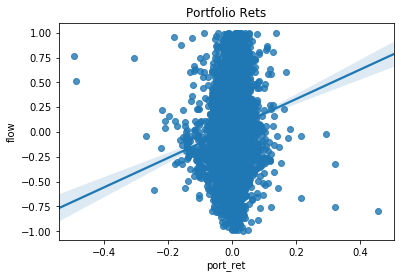

In [62]:
#graph relation between flow and (1) port_ret (2) lag_ret (3) obj_ret (4) lag_obj_ret (5) size
import seaborn as sns

sns.regplot(x='port_ret',y='flow',data=flow2).set_title('Portfolio Rets')

C:\Users\jstar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Lag Rets')

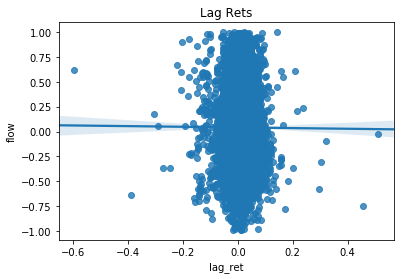

In [63]:
sns.regplot(x='lag_ret',y='flow',data=flow2).set_title('Lag Rets')

C:\Users\jstar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Obj Rets')

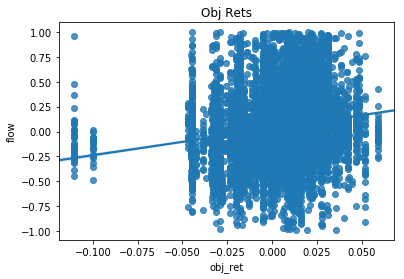

In [64]:
sns.regplot(x='obj_ret',y='flow',data=flow2).set_title('Obj Rets')

C:\Users\jstar\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Lag Obj Rets')

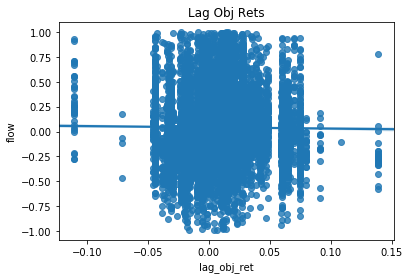

In [65]:
sns.regplot(x='lag_obj_ret',y='flow',data=flow2).set_title('Lag Obj Rets')

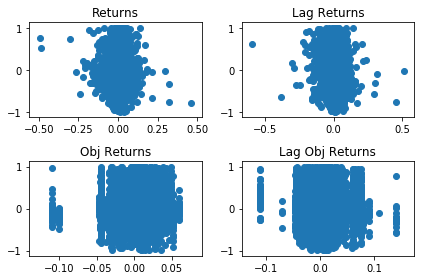

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(2,2,1)
plt.scatter(x='port_ret',y='flow',data=flow2)
plt.title('Returns')
plt.subplot(2,2,2)
plt.scatter(x='lag_ret',y='flow',data=flow2)
plt.title('Lag Returns')
plt.subplot(2,2,3)
plt.scatter(x='obj_ret',y='flow',data=flow2)
plt.title('Obj Returns')
plt.subplot(2,2,4)
plt.scatter(x='lag_obj_ret',y='flow',data=flow2)
plt.title('Lag Obj Returns')

plt.tight_layout()
plt.show()

In [ ]:
### 1 - rolling windows
### 2 - ranks
### 3 - object / strings
### 4 - line of best fit


The results up to this point indicate that investors observe positive performance in mutual funds and invest in those funds. They also observe mutual fund objectives that outperform and invest in those funds as well. This is consistent with investors trying to move money into outperforming mutual funds.
